In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns



In [22]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

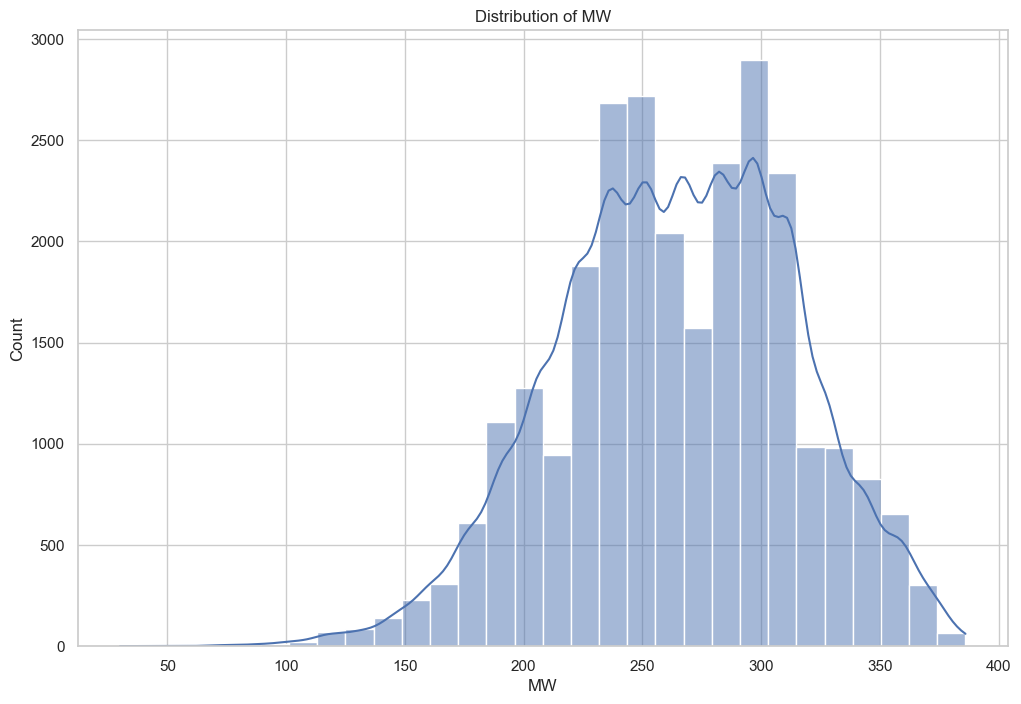

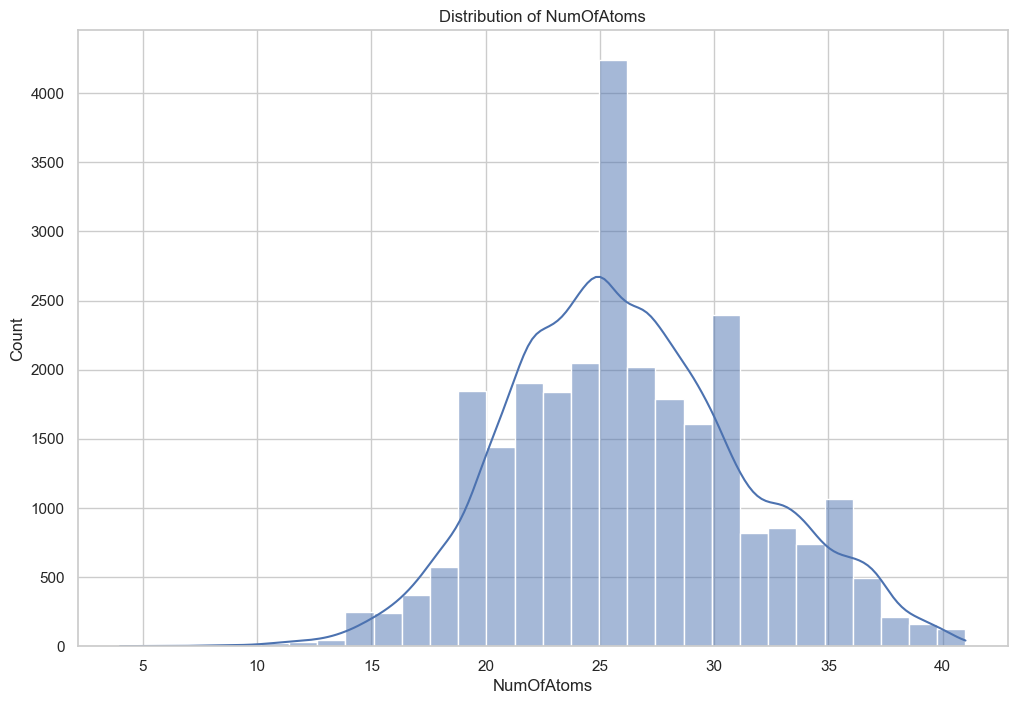

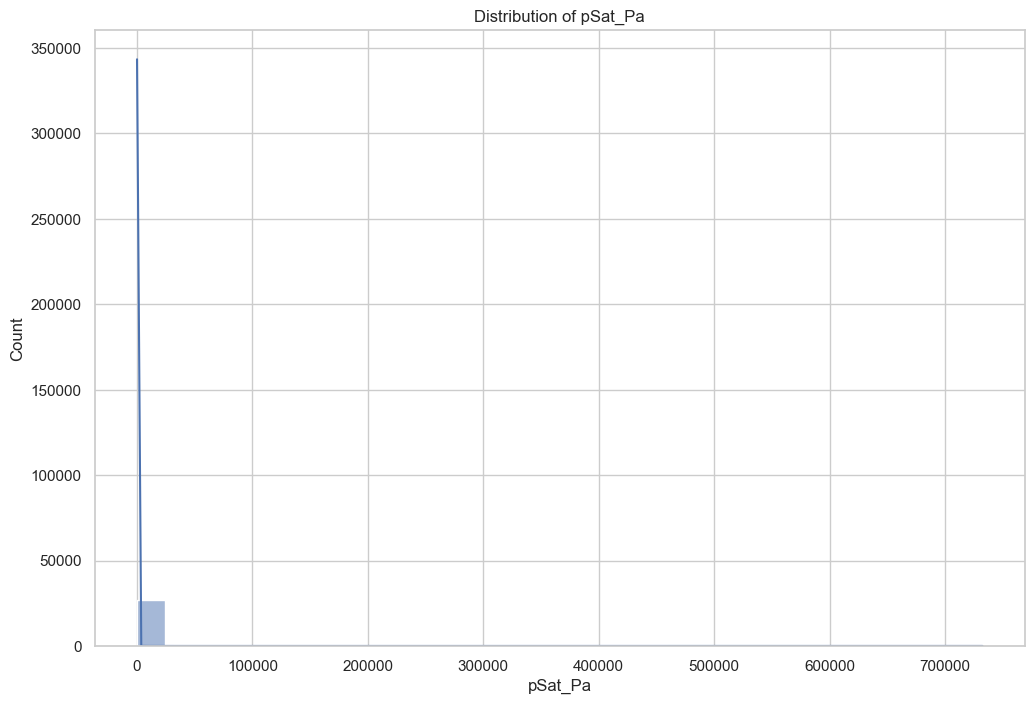

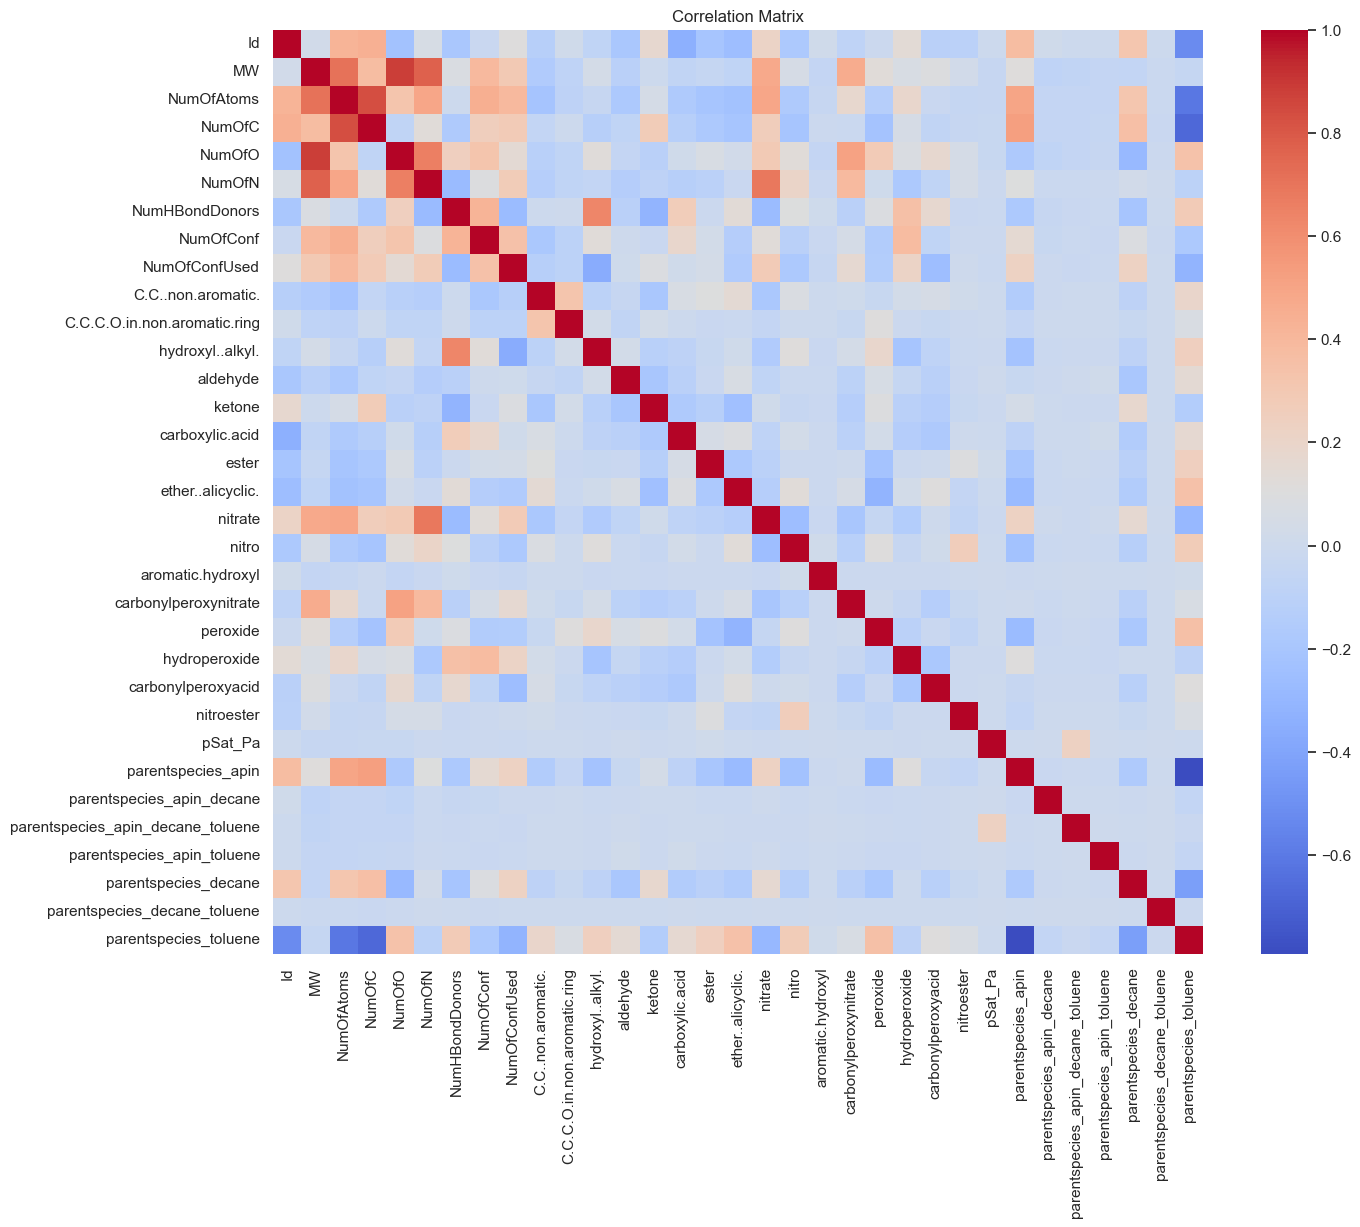

In [23]:


train_df_encoded = pd.get_dummies(train_df, columns=['parentspecies'])
test_df_encoded = pd.get_dummies(test_df, columns=['parentspecies'])

train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1)

missing_values_train = train_df_encoded.isnull().sum()
missing_values_test = test_df_encoded.isnull().sum()

statistical_summary_train = train_df_encoded.describe()

plt.rcParams['figure.figsize'] = [12, 8]
sns.set(style="whitegrid")

features_to_plot = ['MW', 'NumOfAtoms', 'pSat_Pa']
for feature in features_to_plot:
    sns.histplot(train_df_encoded[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

correlation_matrix = train_df_encoded.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


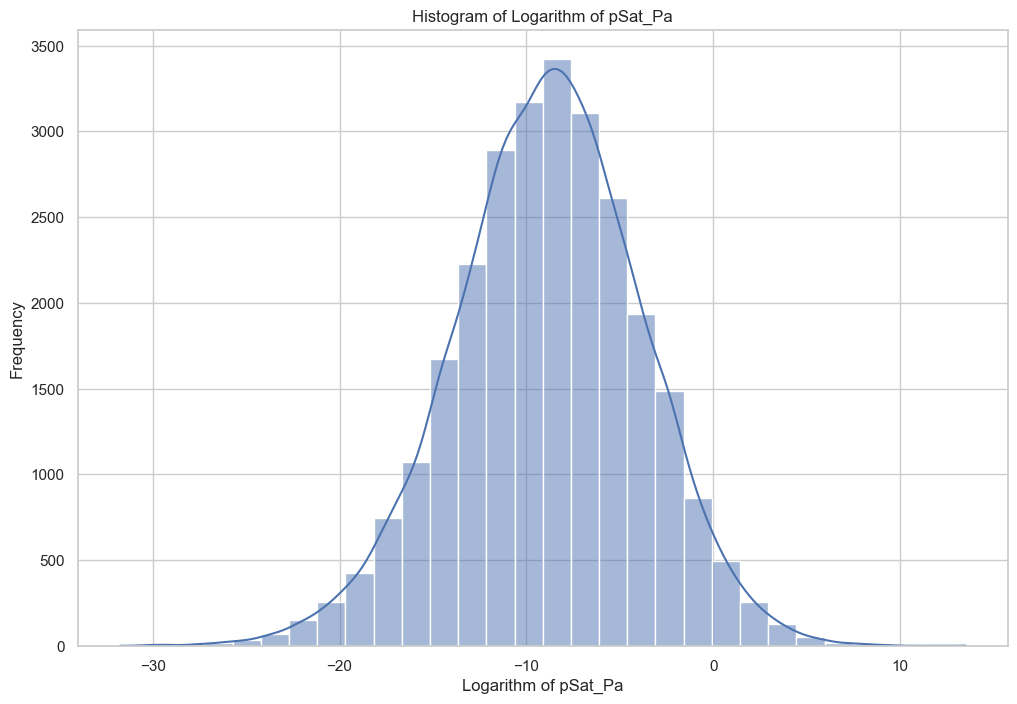

In [10]:
# Distribution of the logarithm of pSat_Pa
log = np.log(train_df['pSat_Pa'])
sns.histplot(log, bins=30, kde=True)
plt.xlabel('Logarithm of pSat_Pa')
plt.ylabel('Frequency')
plt.title('Histogram of Logarithm of pSat_Pa')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = train_df_encoded.drop(['pSat_Pa'], axis=1)
y = train_df_encoded['pSat_Pa']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

r2 = r2_score(y_val, y_pred)
print(f'R2 Score: {r2}')


R2 Score: -69.74463506241622


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)

r2_rf = r2_score(y_val, y_pred_rf)
print(f'R2 Score with Random Forest: {r2_rf}')


R2 Score with Random Forest: -151.37903144197418


In [14]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(verbose=0, random_state=0)
cb_model.fit(X_train, y_train)
y_pred_cb = cb_model.predict(X_val)
r2_cb = r2_score(y_val, y_pred_cb)
print(f'R2 Score with CatBoost: {r2_cb}')

R2 Score with CatBoost: -7.427903926137931


In [15]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f'R2 Score with XGBoost: {r2_xgb}')

R2 Score with XGBoost: -3.846942660075885


without preprocessing linear -69, rf -151, catboost -7,4 xgboost -3.8


In [24]:
train_df['pSat_Pa_log'] = np.log(train_df['pSat_Pa'] + 1e-10)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), train_df.select_dtypes(include=['float64', 'int64']).columns.drop(['Id', 'pSat_Pa', 'pSat_Pa_log'])),
        ('cat', OneHotEncoder(), ['parentspecies'])
    ])

X = train_df.drop(columns=['Id', 'pSat_Pa', 'pSat_Pa_log'])
y = train_df['pSat_Pa_log']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

X_train_preprocessed.shape, X_val_preprocessed.shape


((21717, 32), (5430, 32))

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=0)
cb_model = CatBoostRegressor(verbose=0, random_state=0)
xgb_model = XGBRegressor(random_state=0)

linear_model.fit(X_train_preprocessed, y_train)
y_pred_linear = linear_model.predict(X_val_preprocessed)
print(f'Linear Regression R2 Score: {r2_score(y_val, y_pred_linear)}')

rf_model.fit(X_train_preprocessed, y_train)
y_pred_rf = rf_model.predict(X_val_preprocessed)
print(f'Random Forest R2 Score: {r2_score(y_val, y_pred_rf)}')

cb_model.fit(X_train_preprocessed, y_train)
y_pred_cb = cb_model.predict(X_val_preprocessed)
print(f'CatBoost R2 Score: {r2_score(y_val, y_pred_cb)}')

xgb_model.fit(X_train_preprocessed, y_train)
y_pred_xgb = xgb_model.predict(X_val_preprocessed)
print(f'XGBoost R2 Score: {r2_score(y_val, y_pred_xgb)}')


Linear Regression R2 Score: 0.6975402062639111
Random Forest R2 Score: 0.713100719735424
CatBoost R2 Score: 0.7455342689734983
XGBoost R2 Score: 0.7352081341094057


In [26]:
# Feature importance analysis ----------------------------------------------

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_preprocessed, y_train)

feature_names_num = preprocessor.named_transformers_['num'].get_feature_names_out()
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out()
feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]}")


NumHBondDonors: 0.4706593330699258
NumOfC: 0.12550131172554743
NumOfConf: 0.11104121611961347
NumOfConfUsed: 0.05312764714031523
NumOfAtoms: 0.04527030129232688
MW: 0.02637287578020736
carbonylperoxynitrate: 0.020920643252068914
hydroxyl..alkyl.: 0.020187438897507497
ketone: 0.017881072222399597
carboxylic.acid: 0.016256315216212784
NumOfO: 0.014134993605676568
aldehyde: 0.012607030698214918
peroxide: 0.008951319832078575
hydroperoxide: 0.00888924953761297
carbonylperoxyacid: 0.00776231928400442
C.C..non.aromatic.: 0.007120837310000801
ester: 0.006356053694417473
nitrate: 0.00539931119471069
ether..alicyclic.: 0.005061278484907867
nitro: 0.004615982495891297
parentspecies_apin: 0.002962833919533353
NumOfN: 0.002884397909840736
parentspecies_decane: 0.0019984297893930487
parentspecies_toluene: 0.0014749329492752218
nitroester: 0.0009624933729349903
C.C.C.O.in.non.aromatic.ring: 0.0007002616429253213
parentspecies_nan: 0.0006381894608321887
parentspecies_apin_toluene: 0.00012787747175904

In [27]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_preprocessed)
X_val_poly = poly.transform(X_val_preprocessed)

rf_interaction = RandomForestRegressor(random_state=0)
rf_interaction.fit(X_train_poly, y_train)

interaction_importances = rf_interaction.feature_importances_

sorted_interaction_indices = np.argsort(interaction_importances)[::-1]
interaction_feature_names = poly.get_feature_names_out(feature_names)

for idx in sorted_interaction_indices:
    print(f"{interaction_feature_names[idx]}: {interaction_importances[idx]}")


NumHBondDonors: 0.3156317452575277
NumHBondDonors NumOfConf: 0.13645616323951196
NumOfC NumHBondDonors: 0.04875659334094686
NumHBondDonors carbonylperoxynitrate: 0.043532080227727074
NumOfC NumOfConf: 0.03159017898998205
NumOfC aromatic.hydroxyl: 0.021129211767680258
NumOfC: 0.016234756882667293
NumOfC hydroxyl..alkyl.: 0.01214808926420702
NumOfC nitroester: 0.006880490133458517
NumOfConf ketone: 0.0067944606466242
NumHBondDonors aromatic.hydroxyl: 0.006482636683519393
NumOfConf carbonylperoxyacid: 0.0057931403811036395
NumOfConf hydroperoxide: 0.00578885676766072
NumOfConf NumOfConfUsed: 0.005788262134520348
NumOfConf aldehyde: 0.005751735011088931
NumOfAtoms NumOfConf: 0.005616199470406805
NumOfConf carboxylic.acid: 0.005615073221049116
NumOfO NumOfConf: 0.005551620083792567
NumOfConf peroxide: 0.005493197747757365
NumOfConfUsed ketone: 0.005426413986158146
NumOfConfUsed aldehyde: 0.00526294000944962
NumOfConf hydroxyl..alkyl.: 0.005061288220095942
NumOfConf C.C..non.aromatic.: 0.005

In [29]:
# Threshold for feature importance
importance_threshold = 0.01  # Adjust this value to your needs

important_features = [feature_names[idx] for idx in sorted_indices if importances[idx] > importance_threshold]
important_interactions = [interaction_feature_names[idx] for idx in sorted_interaction_indices if interaction_importances[idx] > importance_threshold]


In [32]:
print(important_features)

['NumHBondDonors', 'NumOfC', 'NumOfConf', 'NumOfConfUsed', 'NumOfAtoms', 'MW', 'carbonylperoxynitrate', 'hydroxyl..alkyl.', 'ketone', 'carboxylic.acid', 'NumOfO', 'aldehyde']


In [33]:

X_important_features = train_df[important_features].copy()

for interaction in important_interactions:
    features = interaction.split(interaction_separator)
    if len(features) == 2 and all(f in train_df.columns for f in features):

        X_important_features[interaction] = train_df[features[0]] * train_df[features[1]]
    elif len(features) != 2:
        print(f"Skipping non-interaction term: {interaction}")


Skipping non-interaction term: NumHBondDonors
Skipping non-interaction term: NumOfC


In [36]:
numerical_features = X_important_features.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = [col for col in X_important_features.columns if col not in numerical_features]

updated_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

updated_preprocessing_pipeline = Pipeline(steps=[('preprocessor', updated_preprocessor)])

# Updated pipeline
X_train, X_val, y_train, y_val = train_test_split(X_important_features, y, test_size=0.2, random_state=0)
X_train_preprocessed = updated_preprocessing_pipeline.fit_transform(X_train)
X_val_preprocessed = updated_preprocessing_pipeline.transform(X_val)


In [42]:

test_df_encoded = test_df_encoded.fillna(0)
X_test_important_features = test_df_encoded[important_features].copy()
for interaction in important_interactions:
    features = interaction.split(' ')
    if len(features) == 2 and all(f in test_df_encoded.columns for f in features):
        X_test_important_features[interaction] = test_df_encoded[features[0]] * test_df_encoded[features[1]]

X_test_preprocessed = updated_preprocessing_pipeline.transform(X_test_important_features)


###################################################################################################################

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=0),
    'XGBoost': XGBRegressor(random_state=0)
}
r2_scores = {}

for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_val_preprocessed)
    r2_scores[name] = r2_score(y_val, y_pred)
    print(f'{name} R2 Score: {r2_scores[name]}')


Linear Regression R2 Score: 0.6855038842026875
Random Forest R2 Score: 0.6926974322768714
CatBoost R2 Score: 0.716979897927591
XGBoost R2 Score: 0.7050628620876105


In [52]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

catboost_model = CatBoostRegressor(verbose=0, random_state=0)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

grid_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='r2')

grid_search.fit(X_train_preprocessed, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_catboost_model = CatBoostRegressor(
    verbose=0,
    random_state=0,
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg']
)

best_catboost_model.fit(X_train_preprocessed, y_train)

y_pred_best = best_catboost_model.predict(X_val_preprocessed)

r2_score_best = r2_score(y_val, y_pred_best)
print(f'Best CatBoost R2 Score: {r2_score_best}')


Best Hyperparameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Best CatBoost R2 Score: 0.7152598896578595


In [53]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

catboost_model = CatBoostRegressor(verbose=0, random_state=0)

param_dist = {
    'iterations': np.arange(100, 501, 100),
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': np.arange(4, 11),
    'l2_leaf_reg': np.arange(1, 11),
}

random_search = RandomizedSearchCV(
    catboost_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='r2', random_state=0
)

random_search.fit(X_train_preprocessed, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_catboost_model = CatBoostRegressor(
    verbose=0,
    random_state=0,
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg']
)

best_catboost_model.fit(X_train_preprocessed, y_train)
y_pred_best = best_catboost_model.predict(X_val_preprocessed)
r2_score_best = r2_score(y_val, y_pred_best)
print(f'Best CatBoost R2 Score: {r2_score_best}')


Best Hyperparameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 4}
Best CatBoost R2 Score: 0.7145301354991989


In [55]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

best_params_grid = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 5,
}

best_catboost_model_grid = CatBoostRegressor(
    verbose=0,
    random_state=0,
    iterations=best_params_grid['iterations'],
    learning_rate=best_params_grid['learning_rate'],
    depth=best_params_grid['depth'],
    l2_leaf_reg=best_params_grid['l2_leaf_reg']
)

best_catboost_model_grid.fit(X_train_preprocessed, y_train)
y_pred_best_grid = best_catboost_model_grid.predict(X_val_preprocessed)
r2_score_best_grid = r2_score(y_val, y_pred_best_grid)
print(f'Best CatBoost (Grid Search) R2 Score: {r2_score_best_grid}')

best_params_random = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 4,
    'l2_leaf_reg': 1,
}

best_catboost_model_random = CatBoostRegressor(
    verbose=0,
    random_state=0,
    iterations=best_params_random['iterations'],
    learning_rate=best_params_random['learning_rate'],
    depth=best_params_random['depth'],
    l2_leaf_reg=best_params_random['l2_leaf_reg']
)

best_catboost_model_random.fit(X_train_preprocessed, y_train)
y_pred_best_random = best_catboost_model_random.predict(X_val_preprocessed)
r2_score_best_random = r2_score(y_val, y_pred_best_random)
print(f'Best CatBoost (Random Search) R2 Score: {r2_score_best_random}')


Best CatBoost (Grid Search) R2 Score: 0.7152598896578595
Best CatBoost (Random Search) R2 Score: 0.7145301354991989


In [56]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

best_params_grid = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 5,
}

best_params_random = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 4,
    'l2_leaf_reg': 1,
}

model_grid = CatBoostRegressor(verbose=0, random_state=0, **best_params_grid)
model_random = CatBoostRegressor(verbose=0, random_state=0, **best_params_random)

cv_scores_grid = cross_val_score(model_grid, X_train_preprocessed, y_train, cv=5, scoring='r2')
cv_scores_random = cross_val_score(model_random, X_train_preprocessed, y_train, cv=5, scoring='r2')

model_grid.fit(X_train_preprocessed, y_train)
model_random.fit(X_train_preprocessed, y_train)

y_pred_grid = model_grid.predict(X_val_preprocessed)
y_pred_random = model_random.predict(X_val_preprocessed)

r2_score_grid = r2_score(y_val, y_pred_grid)
r2_score_random = r2_score(y_val, y_pred_random)

print("Cross-Validation R2 Scores:")
print("Grid Search Model:", cv_scores_grid)
print("Random Search Model:", cv_scores_random)

print("\nValidation Dataset R2 Scores:")
print("Grid Search Model:", r2_score_grid)
print("Random Search Model:", r2_score_random)


Cross-Validation R2 Scores:
Grid Search Model: [0.71365842 0.73640524 0.72229889 0.72163187 0.71912393]
Random Search Model: [0.71242535 0.73611093 0.72086328 0.72168788 0.71865169]

Validation Dataset R2 Scores:
Grid Search Model: 0.7152598896578595
Random Search Model: 0.7145301354991989


In [48]:
test_ids = test_df['Id'].tolist()
submission_df = pd.DataFrame(columns=['Id'])
for name, model in models.items():
    test_predictions = model.predict(X_test_preprocessed)
    submission_df[name] = test_predictions
submission_df['Id'] = test_ids
submission_df.to_csv('competition_submission.csv', index=False)


In [57]:
import pandas as pd
from catboost import CatBoostRegressor

best_params_grid = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 5,
}

best_catboost_model = CatBoostRegressor(verbose=0, random_state=0, **best_params_grid)
best_catboost_model.fit(X_train_preprocessed, y_train)
y_pred_test = best_catboost_model.predict(X_test_preprocessed)
submission_df = pd.DataFrame({'Id': test_ids, 'target': y_pred_test})
submission_df.to_csv('competition_submission_catboost.csv', index=False)
